In [80]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
import math
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


In [81]:
df = pd.read_csv('./input/monthly-beer-production-in-austr.csv')
df

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


Подготовим данные

In [82]:
df.Month = pd.to_datetime(df.Month)
df = df.rename(columns={"Monthly beer production" : "Beer_Prod"})
df = df.set_index('Month')
df.index.freq = 'MS'
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Freq: MS
Data columns (total 1 columns):
Beer_Prod    476 non-null float64
dtypes: float64(1)
memory usage: 7.4 KB
None
        Beer_Prod
count  476.000000
mean   136.395378
std     33.738725
min     64.800000
25%    112.900000
50%    139.150000
75%    158.825000
max    217.800000


In [83]:
df.Beer_Prod

Month
1956-01-01     93.2
1956-02-01     96.0
1956-03-01     95.2
1956-04-01     77.1
1956-05-01     70.9
              ...  
1995-04-01    127.0
1995-05-01    151.0
1995-06-01    130.0
1995-07-01    119.0
1995-08-01    153.0
Freq: MS, Name: Beer_Prod, Length: 476, dtype: float64

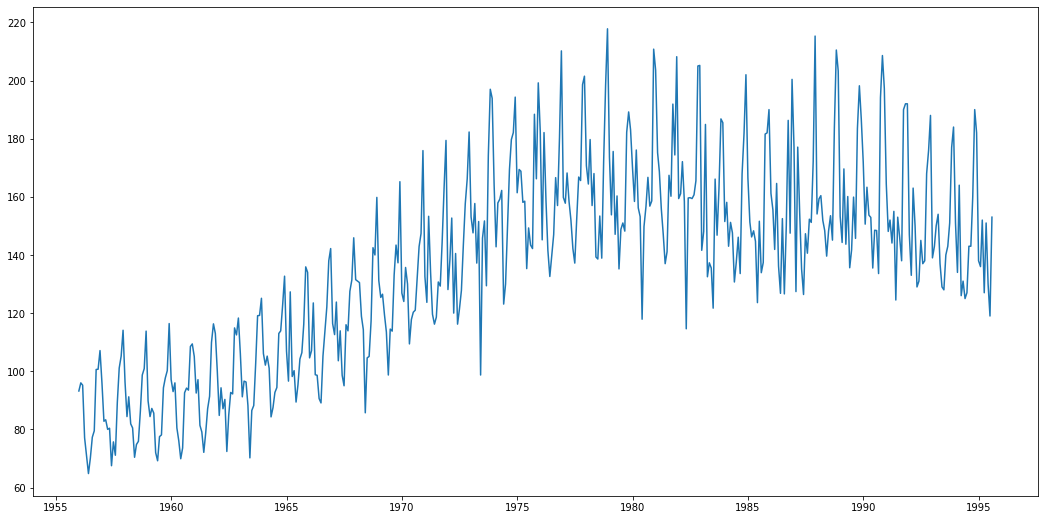

In [84]:
plt.figure(figsize=(18,9))
plt.plot(df.Beer_Prod)

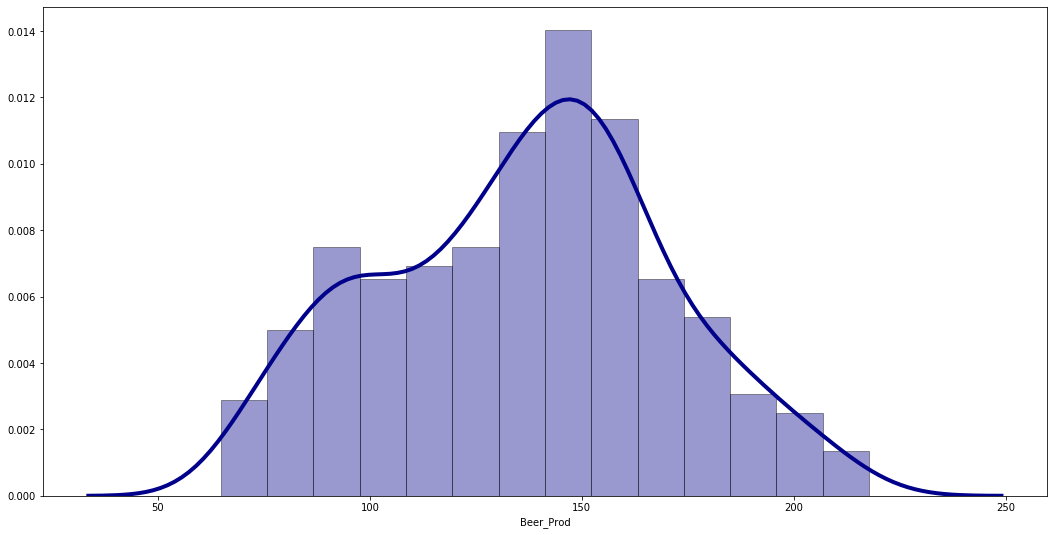

In [85]:
plt.figure(figsize=(18,9))
sns.distplot(df.Beer_Prod, hist=True, color = 'darkblue', #norm_hist=True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Распределение похоже на нормальное! Отлично! продолжаем!

Тут я прослоупочил сезонность данных, но это и работа над ошибками.

! from statsmodels.tsa.seasonal import seasonal_decompose 

! a = seasonal_decompose(df["Monthly beer production"], model = "add")

! a.plot();

но пришлось к ним вернуться((

### Проверка на стационарность
Для этого испоользуем тест Дики-Фуллера

In [86]:
# Это я честно украл у одного индуса
def test_stationarity(timeseries):
    
    #Определяем плавающие статистики
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Рисуем их
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Выполняем расширенный тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    # Тут происходит что-то странное, т.к. у индуса  передается одно значение, а у меня 2 =(
    # Поэтому индийское комментим, а свое оставляем
#     dftest = adfuller(timeseries)
    dftest = adfuller(df.Beer_Prod, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

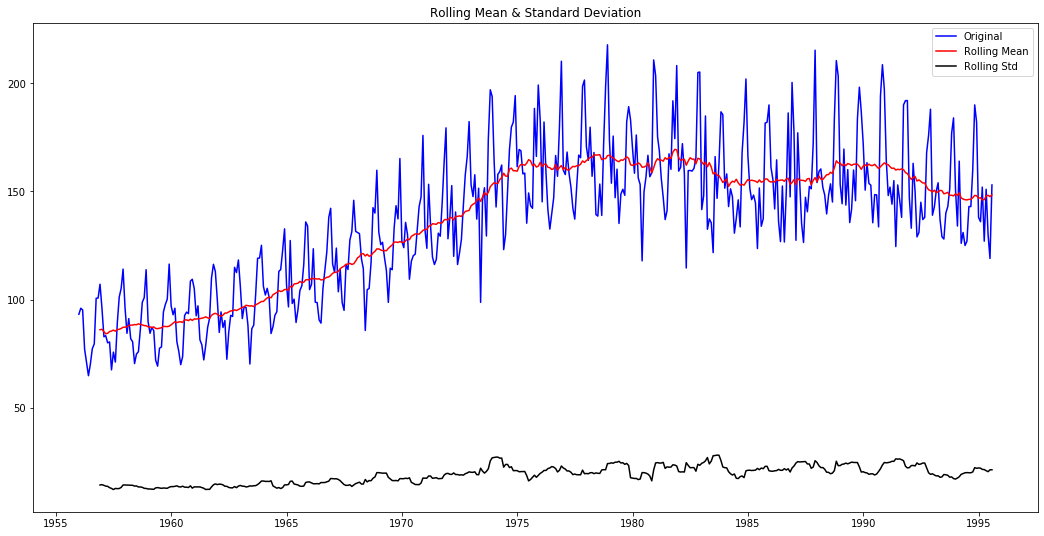

Results of Dickey-Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [87]:
plt.figure(figsize=(18,9))
test_stationarity(df)

1) p- значение больше 0.05, значить нулевая гипотеза о том, что данные стационарны не верна

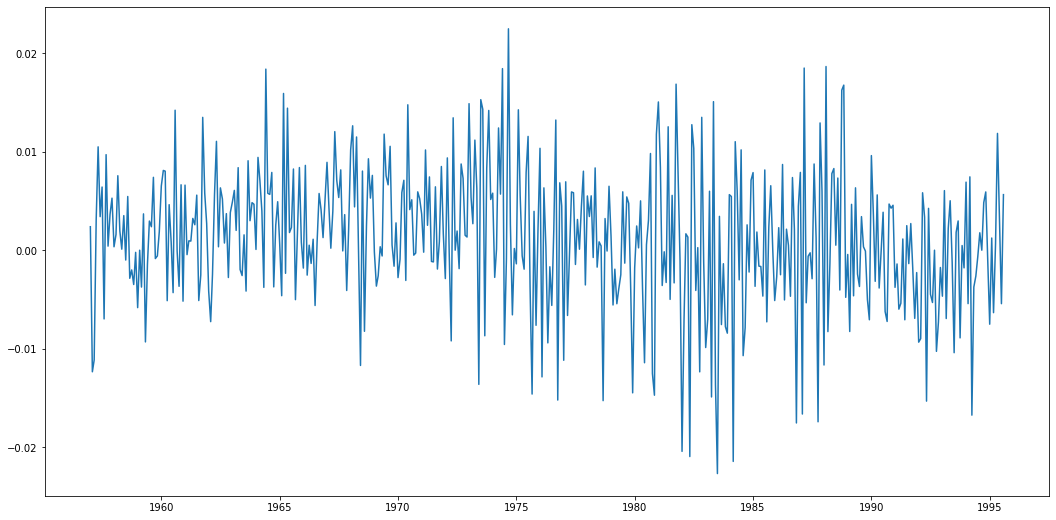

In [88]:
plt.figure(figsize=(18,9))
plt.plot(df['Beer_Prod'].apply(lambda x: math.log(x)).rolling(12).mean().diff(1))

Посмотрим на сезонность данных, т.к. график выше говорит нам о том, что прямой взаимосвязи мы не увидим

In [96]:
pd.plotting.register_matplotlib_converters()

Это какой то квест, состоящий из нерабочего кода чуть менее, чем наполовину
У кого-то работает, у меня нет. Обида блин.
https://darektidwell.com/typeerror-float-argument-must-be-a-string-or-a-number-not-period-facebook-prophet-and-pandas/
Чтоб сезонная декомпозиция работала

<Figure size 1296x648 with 0 Axes>

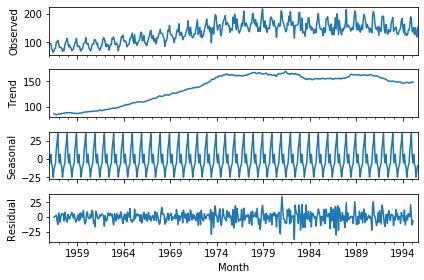

In [99]:
season = seasonal_decompose(df.Beer_Prod, model = "add")
plt.figure(figsize=(18,9))
season.plot();

О! Смотря на 3й график видно, что у нас четкая зависимость от сезона

Это как с мороженным:
    - зимой спрос выше
    - летом ниже